* Consider the classical Ising model on a single square with only four sites. The four Ising spins denoted by $s_{i}(i=1,2,3,4)$ locate on the four corners of the square
    * Each spin can be up or down, represented by $s_{i}=0$ and $1,$ respectively
    * The classical Hamiltonian of such a system reads
$$
H_{s_{1} s_{2} s_{3} s_{4}}=J\left(s_{1} s_{2}+s_{2} s_{3}+s_{3} s_{4}+s_{4} s_{1}\right)+h\left(s_{1}+s_{2}+s_{3}+s_{4}\right)
$$
    * $J$ is the coupling constant and $h$ the magnetic field.
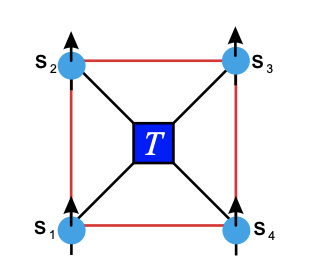
* When the model reaches the equilibrium at temperature $T$, the probability of each possible spin configuration is determined by the Maxwell-Boltzmann factor
$$
T_{s_{1} s_{2} s_{3} s_{4}}=e^{-\beta H_{s_{1} s_{2} s_{3} s_{4}}}
$$
    * $\beta=1 / \mathrm{T} $ is the inverse temperature 
    * We can implement all the different $T_{s_{1} s_{2} s_{3} s_{4}}$ as  a forth-order tensor $T$ where each element gives the probability of the corresponding configuration
    * Thus, the tensor is of rank 4 (has 4 dimensions): one for each spin
        * Each dimension has 2 slots, one for spin 1 and one for spin -1

In [2]:
import numpy as np
np.set_printoptions(precision = 10, suppress=True)
def T_tensor_one_square(J = -1, h = 0, temp = 1): # default: Ising ferromagnet at zero field
    T = np.zeros(shape=(2,2,2,2))
    spins = [-1, 1]
    for id_s1, s1 in enumerate(spins):
        for id_s2, s2 in enumerate(spins):
            for id_s3, s3 in enumerate(spins):
                for id_s4, s4 in enumerate(spins):
                    Hamiltonian = J * (s1 * s2 + s2 * s3 + s3 * s4 + s4 * s1) + h * (s1 + s2 + s3 + s4)
                    prob = np.exp(-1.0/temp * Hamiltonian)
                    T[id_s1, id_s2, id_s3, id_s4] = prob
    return T
                    
T = T_tensor_one_square()

* The partition function is defined as the summation of the probability of all configurations.
    * In the language of tensor, it is obtained by simply summing over all indexes as
$$
Z=\sum_{s_{1} s_{2} s_{3} s_{4}} T_{s_{1} s_{2} s_{3} s_{4}}
$$

In [48]:
def Z_one_square(T):
    # We expect tensor to be of shape (2,2,2,2)
    return np.sum(T)


print("The partition function of the one square Ising model is", Z_one_square(T))

The partition function of the one square Ising model is 121.23293134406595


* Consider Ising spins on 4 squares
    * The partition function can be written with four tensors as
$$
Z=\sum_{\left\{s s^{\prime}\right\}} T_{s_{1} s_{2} s_{2}^{\prime} s_{1}^{\prime}} T_{s_{2}^{\prime} s_{3} s_{4} s_{3}^{\prime}} T_{s_{4}^{\prime} s_{3}^{\prime} s_{5} s_{6}} T_{s_{8} s_{1}^{\prime} s_{4}^{\prime} s_{7}}
$$
    * To see this, note that each tensor in the following tensor accounts for the interactions within a square. Together all interactions are accounted for.
    * The tensors are multiplied because an additive term in the Hamiltonian corresponds to a multiplication of the local energy "contributions" into the probability
    * Note that due to the translational invariance of the Ising model, the tensors at each site are the same
        * We don't have to worry about double-counting the $h$ terms because we're at zero-field $h=0$
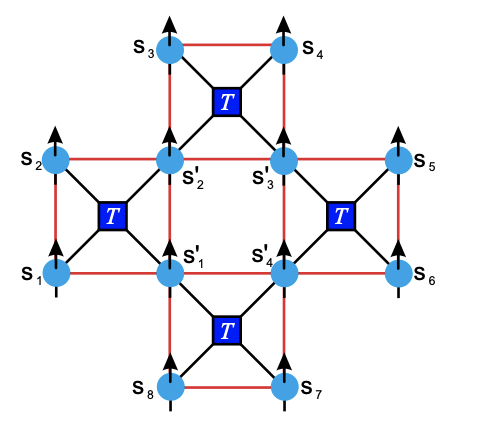
* This model has 12 spins (12 degrees of freedom) and thus should be represented by a rank-12 tensor

* When we multiply 

In [81]:
def T_tensor_four_squares(J = -1, h = 0, temp = 1):
    # We name from the tensor at spins s1, s2, s1', s2' to be tensor a, and then alphabetically clockwise
    tensor_a, tensor_b, tensor_c, tensor_d = [T_tensor_one_square(J, h, temp), T_tensor_one_square(J+2, h, temp), T_tensor_one_square(J+4, h, temp), T_tensor_one_square(J+6, h, temp)] 
    # Recall that the tensors are translationall invariant, so they're the same at all 4 sites
    
    # The spins are arranged clockwise, starting from the bottom left
    # Thus for tensor a: s1 occupies dimension 1, s2 dimension 2, s2' dimension 3, s1' dimension 4
    # Thus dimension 3 of tensor a is contracted with dimension 1 of tensor b
    # For pedagogical purposes, we perform the sum 1 at a time
    # tensor_ab is the result of contracting tensor a with tensor b
    tensor_ab = np.einsum('abcd,cefg->abcdefg', tensor_a, tensor_b)
    
    # tensor_abc is the result of contracting tensor_ab with tensor c
    # We contract the dimension corresponding with spin s_3' (the last index) in tensor_ab
    # with dimension 2 in tensor c (corresponding to spin s_3')
    tensor_abc = np.einsum('abcdefg,hgij->abcdefghij', tensor_ab, tensor_c)
    
    # We contract spins s_4' and s_1' (because tensor d is connected to both a and c)
    tensor_abcd = np.einsum('abcdefghij,kdhl->abcdefghijkl', tensor_abc, tensor_d)
    return tensor_abcd
T_tensor_four_squares().sum()

5.4921351683160904e+16

The idea of TRG is to iteratively "coarse-grain" the TN without changing the bond dimensions, the geometry of the network, and the translational invariance. Such a process is realized by two local operations in each iteration. Let us denote the tensor in the $t$ -th iteration as $T^{(t)}$ (we take $T^{(0)}=T$ ). For obtaining $T^{(t+1)},$ the first step is to decompose $T^{(t)}$ by SVD in two different ways
$$
\begin{aligned}
T_{a_{1} a_{2} a_{3} a_{4}}^{(t)} &=\sum_{b} U_{a_{1} a_{2} b} V_{a_{3} a_{4} b} \\
T_{a_{1} a_{2} a_{3} a_{4}}^{(t)} &=\sum_{b} X_{a_{4} a_{1} b} Y_{a_{2} a_{3} b}
\end{aligned}
$$
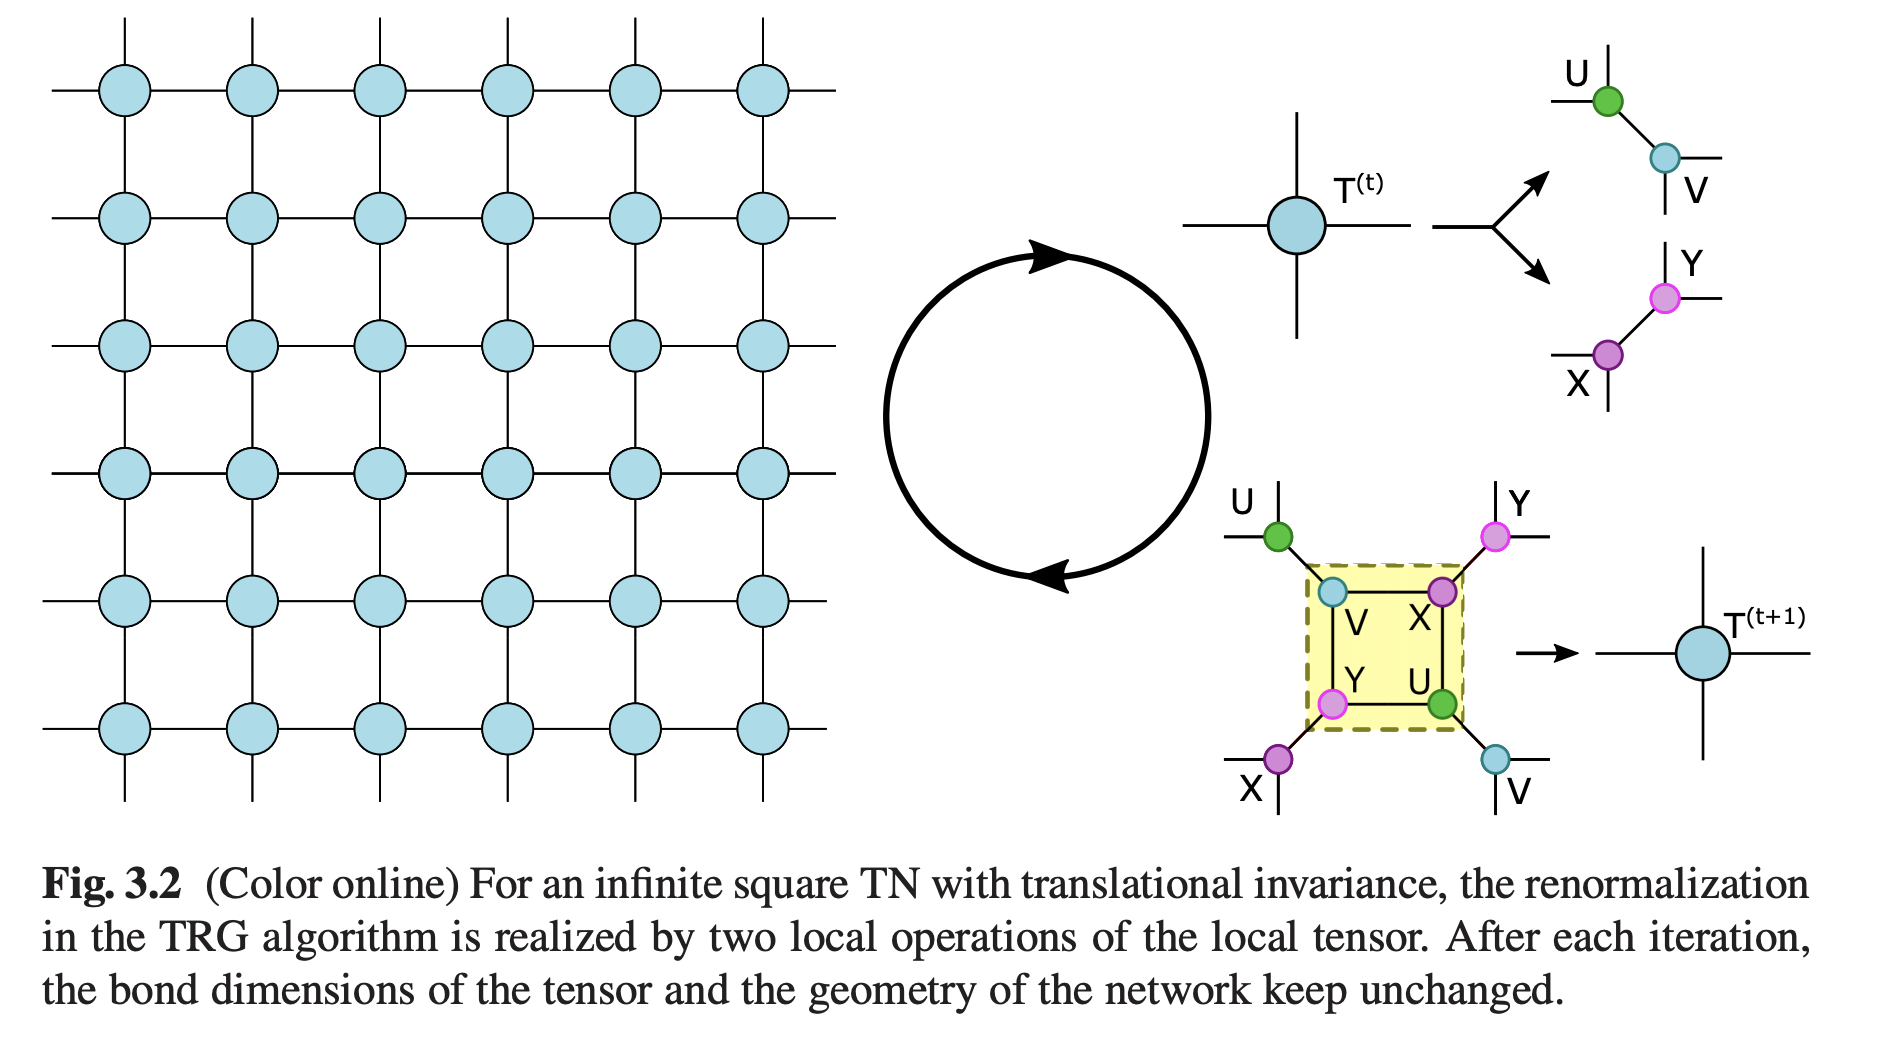


In [175]:
def renormalize_four_squares(J = -1, h = 0, temp = 1):
    # We name from the tensor at spins s1, s2, s1', s2' to be tensor a, and then alphabetically clockwise
    tensor_a, tensor_b, tensor_c, tensor_d = [T_tensor_one_square(J, h, temp), T_tensor_one_square(J+2, h, temp), T_tensor_one_square(J+4, h, temp), T_tensor_one_square(J+6, h, temp)] 
    
    flatten_A = tensor_a.reshape(tensor_a.shape[0] * tensor_a.shape[1], tensor_a.shape[2] * tensor_a.shape[3])
    U_a, S_a, V_a = np.linalg.svd(flatten_A)
    
    U_a_tensor = U_a.dot(np.diag(S_a)).reshape(2, 2, -1) # a1, a2, b
    V_a_tensor = V_a.reshape(-1, 2, 2) # b, a3, a4
    
    T = np.einsum('abz,zcd->abcd', U_a_tensor, V_a_tensor) # a1, a2, a3, a4
    
    
    flatten_B = np.transpose(tensor_b, [3, 0, 1, 2]).reshape(tensor_b.shape[3] * tensor_b.shape[0], \
                                                             tensor_b.shape[1] * tensor_b.shape[2])
    U_b, S_b, V_b = np.linalg.svd(flatten_B)
    
    U_b_tensor = U_b.dot(np.diag(S_b)).reshape(2, 2, -1) # a4, a1, b
    V_b_tensor = V_b.reshape(-1, 2, 2) # b, a2, a3
    
    print(T.shape)
    print(U_b_tensor.shape)
    T = np.einsum('abcd,dez->abcez', T, U_b_tensor) # a1, a2, a3, a1, b
    print(T.shape)
    T = np.einsum('abcez,zfg->abcefg', T, V_b_tensor) # a1, a2, a3, a1, a2, a3
    
    
    flatten_C = tensor_c.reshape(tensor_c.shape[0] * tensor_c.shape[1], tensor_c.shape[2] * tensor_c.shape[3])
    U_c, S_c, V_c = np.linalg.svd(flatten_C)
    
    U_c_tensor = U_c.dot(np.diag(S_c)).reshape(2, 2, -1) # a1, a2, b
    V_c_tensor = V_c.reshape(-1, 2, 2) # b, a3, a4
    
    T = np.einsum('abcefg,ehz->abcfghz', T, U_c_tensor) # a1, a2, a3, a2, a3, a2, b
    T = np.einsum('abcfghz,zij->abcfghij', T, V_c_tensor) # a1, a2, a3, a2, a3, a2, a3, a4
    
    
    flatten_D = np.transpose(tensor_d, [3, 0, 1, 2]).reshape(tensor_d.shape[3] * tensor_d.shape[0], \
                                                             tensor_d.shape[1] * tensor_d.shape[2])
    U_d, S_d, V_d = np.linalg.svd(flatten_D)
    
    U_d_tensor = U_d.dot(np.diag(S_d)).reshape(2, 2, -1) # a4, a1, b
    V_d_tensor = V_d.reshape(-1, 2, 2) # b, a2, a3
    
    T = np.einsum('abcfghij,zhc->abfgijz', T, V_d_tensor) # a1, a2, a2, a3, b, a3, a4
    T = np.einsum('abfgijz,klz->abfgijkl', T, U_d_tensor)
    np.einsum(V, X, U, Y)
    print(T.shape)
    print(T.sum())
    
renormalize_four_squares()

(2, 2, 2, 2)
(2, 2, 4)
(2, 2, 2, 2, 4)
(2, 2, 2, 2, 2, 2, 2, 2)
5.492135168316105e+16


In [173]:
def reconstruct(U, S, keep_dim):
    S_n = np.zeros(U.shape)
    S_n[:keep_dim,:keep_dim] = np.diag(S)[:keep_dim,:keep_dim]
    
    return(U.dot(S_n))   
def renormalize_four_squares_approximate(J = -1, h = 0, temp = 1):
    # We name from the tensor at spins s1, s2, s1', s2' to be tensor a, and then alphabetically clockwise
    tensor_a, tensor_b, tensor_c, tensor_d = [T_tensor_one_square(J, h, temp), T_tensor_one_square(J+2, h, temp), T_tensor_one_square(J+4, h, temp), T_tensor_one_square(J+6, h, temp)] 
    
    flatten_A = tensor_a.reshape(tensor_a.shape[0] * tensor_a.shape[1], tensor_a.shape[2] * tensor_a.shape[3])
    U_a, S_a, V_a = np.linalg.svd(flatten_A)
    
    U_a_tensor = reconstruct(U_a, S_a, 2).reshape(2, 2, -1) # a1, a2, b
    V_a_tensor = V_a.reshape(-1, 2, 2) # b, a3, a4
    
    T = np.einsum('abz,zcd->abcd', U_a_tensor, V_a_tensor) # a1, a2, a3, a4
    
    
    flatten_B = np.transpose(tensor_b, [3, 0, 1, 2]).reshape(tensor_b.shape[3] * tensor_b.shape[0], \
                                                             tensor_b.shape[1] * tensor_b.shape[2])
    U_b, S_b, V_b = np.linalg.svd(flatten_B)
    
    U_b_tensor = reconstruct(U_b, S_b, 2).reshape(2, 2, -1) # a4, a1, b
    V_b_tensor = V_b.reshape(-1, 2, 2) # b, a2, a3
    
    print(T.shape)
    print(U_b_tensor.shape)
    T = np.einsum('abcd,dez->abcez', T, U_b_tensor) # a1, a2, a3, a1, b
    print(T.shape)
    T = np.einsum('abcez,zfg->abcefg', T, V_b_tensor) # a1, a2, a3, a1, a2, a3
    
    
    flatten_C = tensor_c.reshape(tensor_c.shape[0] * tensor_c.shape[1], tensor_c.shape[2] * tensor_c.shape[3])
    U_c, S_c, V_c = np.linalg.svd(flatten_C)
    
    U_c_tensor = reconstruct(U_c, S_c, 2).reshape(2, 2, -1) # a1, a2, b
    V_c_tensor = V_c.reshape(-1, 2, 2) # b, a3, a4
    
    T = np.einsum('abcefg,ehz->abcfghz', T, U_c_tensor) # a1, a2, a3, a2, a3, a2, b
    T = np.einsum('abcfghz,zij->abcfghij', T, V_c_tensor) # a1, a2, a3, a2, a3, a2, a3, a4
    
    
    flatten_D = np.transpose(tensor_d, [3, 0, 1, 2]).reshape(tensor_d.shape[3] * tensor_d.shape[0], \
                                                             tensor_d.shape[1] * tensor_d.shape[2])
    U_d, S_d, V_d = np.linalg.svd(flatten_D)
    
    U_d_tensor = reconstruct(U_d, S_d, 2).reshape(2, 2, -1) # a4, a1, b
    V_d_tensor = V_d.reshape(-1, 2, 2) # b, a2, a3
    
    T = np.einsum('abcfghij,zhc->abfgijz', T, V_d_tensor) # a1, a2, a2, a3, b, a3, a4
    T = np.einsum('abfgijz,klz->abfgijkl', T, U_d_tensor)
    print(T.sum())
    
    
    

renormalize_four_squares_approximate()    

(2, 2, 2, 2)
(2, 2, 4)
(2, 2, 2, 2, 4)
3.839715019180211e+16


# References
https://arxiv.org/pdf/1708.09213.pdf 

In [86]:
T = np.random.randn(10,10,10,10)
flatten_T = np.transpose(T, ).reshape(T.shape[0] * T.shape[1], T.shape[2] * T.shape[3])

In [87]:
flatten_T

array([[-0.9379073922, -2.0434314118, -0.2396923377, ..., -0.1010325069,
         1.3464571026,  0.2192227521],
       [-0.7767678352,  0.8149633966, -0.7828159483, ...,  0.6195548783,
        -0.6571562583, -0.4207283961],
       [-0.3457572445, -1.0379118367,  1.5633779042, ..., -0.4018859963,
         0.4412619655,  1.2751461703],
       ...,
       [ 1.468437695 ,  1.9492612324, -0.826673861 , ..., -2.1474972148,
        -0.9241615832,  0.2329263363],
       [-0.2149070054, -0.7430987518, -0.7581571503, ..., -2.8827298525,
         0.7685651462,  0.4978970919],
       [ 0.7680136968,  0.4389755874, -0.403232893 , ..., -0.6407021565,
         1.2285013961, -0.3374387918]])

In [151]:
U, S, V = np.linalg.svd(flatten_T)

In [152]:
S

array([21.2024418679, 19.6722519066, 18.450678943 , 18.0738567012,
       17.5613291456, 16.9699785023, 16.6450075238, 16.2870410673,
       16.227972984 , 16.1307146964,  2.685390434 ,  2.2561689357,
        2.2121390002,  2.0869825303,  2.0055659165,  1.9940811679,
        1.9571613575,  1.842995192 ,  1.676690799 ,  1.6287697926,
        1.6172104112,  1.5372015531,  1.4629980873,  1.4223724217,
        1.4069181818,  1.3743425045,  1.3534691584,  1.334722005 ,
        1.2930590665,  1.2739680562,  1.2702088643,  1.2645986122,
        1.2617822268,  1.2385899389,  1.2240796613,  1.2147406535,
        1.2117184777,  1.1738100912,  1.1429453893,  1.1234477705,
        1.1121927956,  1.1109165777,  1.0505667397,  1.0481693276,
        1.0467164944,  1.0443069001,  1.0093583915,  1.0082102209,
        0.9943328063,  0.9765634437,  0.9420669043,  0.9242808095,
        0.8980934153,  0.8936369382,  0.8175685761,  0.7851641872,
        0.7789426554,  0.7724077585,  0.7648071832,  0.7597205

In [153]:
def reconstruct(U, S, V, keep_dim):
    S_n = np.zeros(U.shape)
    S_n[:keep_dim,:keep_dim] = np.diag(S)[:keep_dim,:keep_dim]
    
    return(U.dot(S_n).dot(V))

In [172]:
(flatten_T - reconstruct(U, S, V, 100)).sum()

-5.1791443312840246e-14

In [155]:
flatten_T

array([[ 0.2477302936, -0.0160044926,  0.4674507825, ..., -0.41186009  ,
         0.9674748625,  0.3858507239],
       [-0.0413749585,  0.6844673224, -0.8065301408, ...,  1.0528511979,
         0.0543657458, -0.27846301  ],
       [-0.7812905934, -0.7512883192,  0.3503989958, ...,  0.3497033961,
        -0.0295917982, -0.125210938 ],
       ...,
       [-0.1729756115,  0.5879251238, -0.041250063 , ..., -1.5330096727,
         0.2868462834,  0.5183767433],
       [-0.5235612946, -0.2459191869,  0.0304062642, ..., -0.9170386907,
         0.064356342 , -0.0065683087],
       [-0.3122393308, -0.0627034727, -0.0140561768, ..., -0.1167258992,
         0.5150046984,  0.2361076165]])

In [149]:
S[10:] = 0

In [150]:
flatten_T = U.dot(np.diag(S + np.random.randn(S.shape[0]))).dot(V)

In [375]:
def get_element_abcd(dims,U=U,S=S,V=V,T=T):
    a,b,c,d=dims
    shape1, shape2, shape3, shape4 = T.shape
    return (U[a * shape2 + b, :len(S)] * S).dot(V[:, c * shape4 + d]) 
    
    

In [357]:
get_element_abcd([1,3,2,6])

1.5988367547075946

In [358]:
T[1,3,2,6]

1.5988367547075906

In [359]:
T[(6,4,1,2)]

-1.6532169416674476

In [366]:
l = []
for _ in range(100000):
    rand = np.random.randint(10, size=4)
    if (get_element_abcd(rand) - T[tuple(rand)] > 1e-5):
        print("Oh no")

In [367]:
flatten_T = np.transpose(T, [3, 0, 1, 2]).reshape(T.shape[0] * T.shape[1], T.shape[2] * T.shape[3])
U, S, V = np.linalg.svd(flatten_T)

In [376]:
get_element_abcd([3,4,2,5])

2.0587101866691286

In [377]:
T[4,2,5,3]

2.058710186669129

In [197]:
S_new = np.zeros(np.tile(np.where(U.shape[0] < V.shape[0], V.shape[0], U.shape[0]), 1))
S_new[:len(S)] = S
# print(S_new)
V_new = V.reshape(-1, 3, 3)
for a in range(T.shape[0]):
    for b in range(T.shape[1]):
        for c in range(T.shape[2]):
#             print(T[a,b,c])
#             print((U[a,:] * S_new))
            print((T[a,b,c] - (U[a,:] * S_new)[:len(S)].dot(V_new[:,b,c].flatten())) < 1e-10)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [177]:
U.shape

(100, 100)

In [176]:
V

array([[-0.6052165401, -0.2385550399, -0.0878922575, -0.3109342474,
        -0.3951495931, -0.4148828502, -0.0228813734,  0.0765479136,
        -0.3711403465],
       [-0.4367756134,  0.6753649633,  0.4057177681, -0.2563787245,
         0.3310830837,  0.0634189455, -0.0908059964,  0.0253300496,
        -0.0157149861],
       [ 0.5575738477,  0.3927270153, -0.0058553192, -0.3490323293,
        -0.2690876202, -0.2926026933, -0.0360551431, -0.3801218112,
        -0.3304572528],
       [-0.3254905482,  0.3260025112, -0.2110129809,  0.4969242638,
        -0.4172227836,  0.1023849369,  0.0166680473, -0.5302003671,
         0.1742707208],
       [ 0.0636064388,  0.1497837968,  0.1813246175,  0.4627326039,
        -0.1092920386,  0.212305297 ,  0.2721646529,  0.3192246696,
        -0.7025116929],
       [-0.0797411359, -0.1013677433,  0.0305668101, -0.3228769223,
         0.0276717719,  0.2410849345,  0.8657506098, -0.2588236196,
         0.0527317558],
       [-0.0487837587, -0.3480034038,  0

In [150]:
def reconstruct(U,S,V):
    US = U[:,:len(S)].dot(np.diag(S))
    result = np.zeros(shape=(U.shape[0], V.shape[0]))
    result[:US.shape[0],:US.shape[1]] = US
    return result.dot(V)

In [153]:
reconstruct(U,S,V)

array([[ 0.0214475428,  0.7806985943, -0.5746198631],
       [ 0.0786995443,  0.7696743343,  1.8439153627],
       [-0.3347102452, -0.1063237015, -1.2204808806],
       [ 0.3813080674, -0.0494285621, -1.3808637007],
       [-1.4160997856, -0.0674942954,  0.4486761567],
       [ 0.1186161131, -0.5697781951,  0.3237838191],
       [ 1.3228386899, -2.5997340768, -0.4482779904],
       [-0.4179551025, -0.8960179854, -2.0333924524],
       [-0.0679129393,  1.1439415806, -0.5314480198],
       [-0.5828958408, -1.0137408876, -0.2363200187],
       [-0.9428960783,  2.1565495907, -1.7654613025],
       [-1.3450980922,  0.3136387102,  0.9357960032],
       [-0.5439815015,  0.792957524 ,  0.0534472175],
       [-0.5166672116, -0.3065192599,  2.1200894252],
       [-1.4710497548, -0.3922338699, -0.6382643839],
       [ 0.471200539 , -0.5873610198,  1.7758059315],
       [ 0.0832716847, -0.9334764819,  0.3625342998],
       [ 0.4886374228, -0.1052628991, -0.8305652398],
       [-0.3676301837,  0.49

In [154]:
reconstruct(U,S,V).reshape(T.shape) - T

array([[[ 0., -0.,  0.],
        [-0.,  0., -0.],
        [ 0., -0., -0.]],

       [[ 0., -0.,  0.],
        [ 0., -0.,  0.],
        [-0.,  0., -0.]],

       [[-0.,  0., -0.],
        [ 0., -0.,  0.],
        [ 0., -0.,  0.]],

       [[-0.,  0.,  0.],
        [ 0., -0.,  0.],
        [-0.,  0., -0.]],

       [[ 0., -0.,  0.],
        [-0.,  0., -0.],
        [ 0., -0.,  0.]],

       [[-0.,  0., -0.],
        [-0.,  0., -0.],
        [ 0., -0.,  0.]],

       [[-0.,  0.,  0.],
        [-0.,  0., -0.],
        [ 0., -0.,  0.]],

       [[-0.,  0., -0.],
        [-0.,  0., -0.],
        [ 0., -0.,  0.]],

       [[ 0., -0.,  0.],
        [-0.,  0., -0.],
        [ 0., -0.,  0.]],

       [[ 0., -0.,  0.],
        [ 0., -0.,  0.],
        [ 0.,  0., -0.]],

       [[ 0.,  0., -0.],
        [ 0.,  0.,  0.],
        [ 0., -0.,  0.]],

       [[-0.,  0., -0.],
        [-0.,  0., -0.],
        [ 0., -0.,  0.]],

       [[ 0., -0.,  0.],
        [ 0.,  0., -0.],
        [-0.,  0., -0.]],


In [135]:
(S**2).sum()

18.925863478890438

In [120]:
(U**2).sum()

100.00000000000001